TO DO


add duration of absence metric


make sure top/bottom num outliers for this month not same as num absences

In [6]:
import os

import pandas as pd

import mysql.connector

from datetime import datetime

In [7]:
rds_host = os.getenv("ML_RDS_HOST")
rds_user = os.getenv("ML_RDS_USER")
rds_pwd = os.getenv("ML_RDS_PASSWORD")

rds_db = 'rr_core'

In [8]:
# filter only tier 1,2 realms - keep as tuple for mysql query
realms_shortlist = ('gusto', 
                    'camino', 
                    'maray', 
                    'pizzapilgrims', 
                    'signaturepubs', 
                    'brewdog', 
                    'preto', 
                    'temper', 
                    'bonnieandwild', 
                    'brownsofbrockley', 
                    'itison', 
                    'roseacre', 
                    'spaceandthyme', 
                    'housecafes', 
                    'gh4ox1gb', 
                    'namco', 
                    'hotelfolk', 
                    'warnerleisure', 
                    'nq64')

In [59]:
# NB query is about 6 secs for 2024 only, tier 1 and 2 clients or
# 40 secs for tier 1 and 2 clients, or 3 mins for all realms

query = f"""select 
                *,
        -- no. of hours prior to start date the request was submitted
        TIME_TO_SEC(timediff(CONVERT(submit_date, DATETIME),CONVERT(date_start, DATETIME)))/(24*60*60) as request_lt_days 
        from collated_absence_header
        where year(date_start) >= 2024 and cancelled = 0 and approved = 1 and realm in {realms_shortlist}"""

conn = mysql.connector.connect(
        host=rds_host, user=rds_user, password=rds_pwd, database=rds_db
        )

absences = pd.read_sql_query(query, con=conn) # NB this gets closed after returning to main()

conn.close()


/var/folders/t6/ysrkn8dn65b6bsvj1sb28p9m0000gp/T/ipykernel_31641/3047248617.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  absences = pd.read_sql_query(query, con=conn) # NB this gets closed after returning to main()


In [60]:
absences.shape

(131547, 30)

In [12]:
absences.head()

,id,user_id,type_id,date_start,date_end,scope,total_hours,total_days,details,approved,...,start_time_local,end_time_local,payroll_calendar_id,review_message,edited_user_id,edited_date,request_days_not_suggested,type_reason_id,realm,request_lt_days
0,1,6,1,2022-09-12,2022-09-16,0,40.0,5.0,None,1,...,NaT,NaT,1.0,None,NaN,NaT,0,NaN,brownsofbrockley,1.5199
1,1,702,1,2022-02-28,2022-03-04,0,36.0,4.0,None,1,...,NaT,NaT,NaN,None,NaN,NaT,0,NaN,gusto,-16.5460
2,1,136,1,2022-01-31,2022-02-08,0,48.0,6.0,None,1,...,NaT,NaT,NaN,None,NaN,NaT,0,NaN,itison,-4.4284
3,1,1071,1,2020-08-17,2020-08-23,0,37.5,5.0,None,1,...,NaT,NaT,NaN,None,NaN,NaT,0,NaN,pizzapilgrims,-12.6075
4,1,81,1,2022-03-14,2022-03-23,0,100.0,10.0,None,1,...,NaT,NaT,1.0,None,72.0,2023-02-07 14:13:41,0,NaN,preto,0.4323


In [18]:
absences.dtypes

id                                      int64
user_id                                 int64
type_id                                 int64
date_start                     datetime64[ns]
date_end                               object
scope                                   int64
total_hours                           float64
total_days                            float64
details                                object
approved                                int64
approval_userid                       float64
approval_date                  datetime64[ns]
submit_userid                           int64
submit_date                    datetime64[ns]
cancelled                               int64
cancel_userid                          object
cancel_date                            object
external_id                            object
user_hours_day                        float64
user_hours_halfday                    float64
start_time_local              timedelta64[ns]
end_time_local                time

In [20]:
# time info

# convert dates to pandas datetime format
absences['date_start'] = pd.to_datetime(absences['date_start'], format='%Y-%m-%d')

absences['start_year'] = absences['date_start'].dt.year
absences['start_month'] = absences['date_start'].dt.month
absences['start_day'] = absences['date_start'].dt.day

In [21]:
absences.head()

,id,user_id,type_id,date_start,date_end,scope,total_hours,total_days,details,approved,...,review_message,edited_user_id,edited_date,request_days_not_suggested,type_reason_id,realm,request_lt_days,start_year,start_month,start_day
0,1,6,1,2022-09-12,2022-09-16,0,40.0,5.0,None,1,...,None,NaN,NaT,0,NaN,brownsofbrockley,1.5199,2022,9,12
1,1,702,1,2022-02-28,2022-03-04,0,36.0,4.0,None,1,...,None,NaN,NaT,0,NaN,gusto,-16.5460,2022,2,28
2,1,136,1,2022-01-31,2022-02-08,0,48.0,6.0,None,1,...,None,NaN,NaT,0,NaN,itison,-4.4284,2022,1,31
3,1,1071,1,2020-08-17,2020-08-23,0,37.5,5.0,None,1,...,None,NaN,NaT,0,NaN,pizzapilgrims,-12.6075,2020,8,17
4,1,81,1,2022-03-14,2022-03-23,0,100.0,10.0,None,1,...,None,72.0,2023-02-07 14:13:41,0,NaN,preto,0.4323,2022,3,14


In [22]:
# filter this months absences (based on absence start date)
monthly_absences = absences[(absences.start_year==datetime.now().year) & 
                                (absences.start_month==datetime.now().month)]

In [23]:
monthly_absences.shape

(14788, 33)

In [24]:
monthly_absences.describe()

,id,user_id,type_id,date_start,scope,total_hours,total_days,approved,approval_userid,approval_date,...,end_time_local,payroll_calendar_id,edited_user_id,edited_date,request_days_not_suggested,type_reason_id,request_lt_days,start_year,start_month,start_day
count,14788.000000,14788.000000,14788.00000,14788,14788.000000,14788.000000,14788.000000,14788.0,14788.000000,14788,...,346,14721.000000,9629.000000,9629,14788.000000,1422.000000,14788.000000,14788.0,14788.0,14788.000000
mean,236354.248039,5277.760143,75.35610,2024-08-15 17:25:31.728428544,0.199351,16.484268,2.218420,1.0,1892.668583,2024-06-30 04:05:52.493373184,...,0 days 16:11:26.705202312,2.346444,2941.531623,2024-06-22 20:00:02.978710272,0.154517,8.781997,-20.142767,2024.0,8.0,15.726062
min,5.000000,2.000000,1.00000,2024-08-01 00:00:00,0.000000,1.000000,0.500000,1.0,0.000000,2023-01-23 12:36:26,...,0 days 00:00:00,1.000000,1.000000,2023-01-23 12:36:26,0.000000,1.000000,-34.958300,2024.0,8.0,1.000000
25%,35378.750000,1211.000000,1.00000,2024-08-08 00:00:00,0.000000,6.760000,1.000000,1.0,0.000000,2024-06-19 09:40:38.750000128,...,0 days 13:30:00,2.000000,383.000000,2024-06-07 17:53:35,0.000000,7.000000,-34.958300,2024.0,8.0,8.000000
50%,255758.000000,3902.500000,4.00000,2024-08-16 00:00:00,0.000000,8.000000,1.000000,1.0,305.000000,2024-07-25 15:47:58,...,0 days 16:00:00,2.000000,1598.000000,2024-07-18 13:30:51,0.000000,7.000000,-23.372400,2024.0,8.0,16.000000
75%,461836.750000,9799.000000,5.00000,2024-08-23 00:00:00,0.000000,16.882500,2.000000,1.0,2609.000000,2024-08-10 10:46:21.750000128,...,0 days 21:00:00,4.000000,4608.000000,2024-08-04 09:56:46,0.000000,9.000000,-4.446875,2024.0,8.0,23.000000
max,479790.000000,13064.000000,1012.00000,2024-08-31 00:00:00,3.000000,1064.000000,158.000000,1.0,12858.000000,2024-08-27 20:09:50,...,0 days 23:55:00,5.000000,12858.000000,2024-08-27 17:23:36,1.000000,22.000000,21.356500,2024.0,8.0,31.000000
std,189857.411269,4412.012221,259.50928,NaN,0.629643,25.917335,3.592873,0.0,2959.560647,NaN,...,0 days 05:28:37.569509797,1.179856,3243.024185,NaN,0.361456,3.960255,14.705890,0.0,0.0,8.820188


In [25]:
monthly_absences.request_lt_days.describe()

count    14788.000000
mean       -20.142767
std         14.705890
min        -34.958300
25%        -34.958300
50%        -23.372400
75%         -4.446875
max         21.356500
Name: request_lt_days, dtype: float64

In [26]:
monthly_absences.realm.unique()

array(['gh4ox1gb', 'brownsofbrockley', 'spaceandthyme', 'preto',
       'bonnieandwild', 'maray', 'nq64', 'temper', 'camino', 'housecafes',
       'itison', 'gusto', 'roseacre', 'pizzapilgrims', 'namco',
       'signaturepubs', 'brewdog', 'warnerleisure'], dtype=object)

In [27]:
monthly_absences.realm.nunique() # number of realms

18

array([[<Axes: title={'center': 'bonnieandwild'}>,
        <Axes: title={'center': 'brewdog'}>,
        <Axes: title={'center': 'brownsofbrockley'}>,
        <Axes: title={'center': 'camino'}>],
       [<Axes: title={'center': 'gh4ox1gb'}>,
        <Axes: title={'center': 'gusto'}>,
        <Axes: title={'center': 'housecafes'}>,
        <Axes: title={'center': 'itison'}>],
       [<Axes: title={'center': 'maray'}>,
        <Axes: title={'center': 'namco'}>,
        <Axes: title={'center': 'nq64'}>,
        <Axes: title={'center': 'pizzapilgrims'}>],
       [<Axes: title={'center': 'preto'}>,
        <Axes: title={'center': 'roseacre'}>,
        <Axes: title={'center': 'signaturepubs'}>,
        <Axes: title={'center': 'spaceandthyme'}>],
       [<Axes: title={'center': 'temper'}>,
        <Axes: title={'center': 'warnerleisure'}>, <Axes: >, <Axes: >]],
      dtype=object)

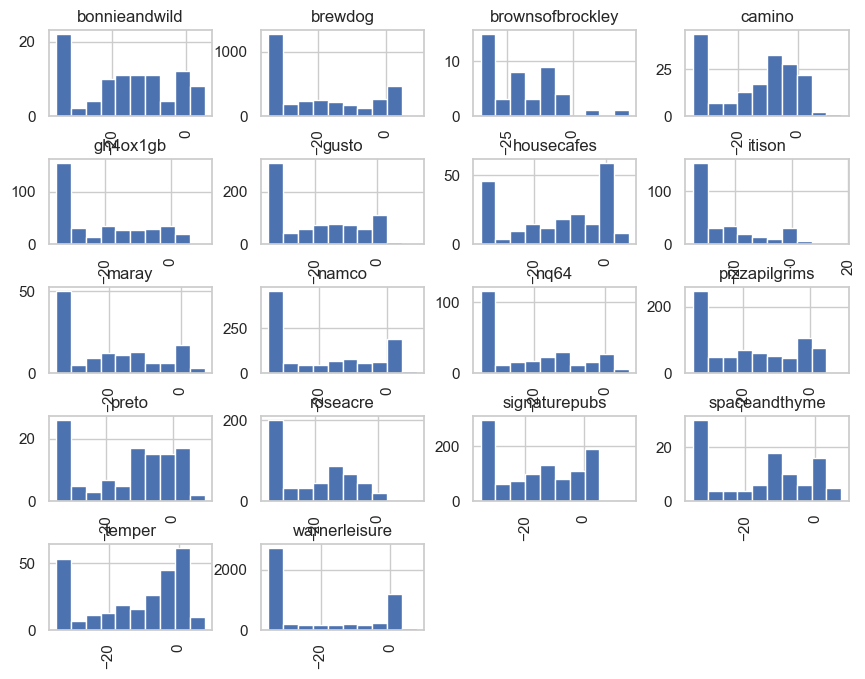

In [42]:
monthly_absences.hist(column="request_lt_days", by="realm", figsize=(10, 8))

/var/folders/t6/ysrkn8dn65b6bsvj1sb28p9m0000gp/T/ipykernel_31641/337730302.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


[Text(0, 0, 'gh4ox1gb'),
 Text(1, 0, 'brownsofbrockley'),
 Text(2, 0, 'spaceandthyme'),
 Text(3, 0, 'preto'),
 Text(4, 0, 'bonnieandwild'),
 Text(5, 0, 'maray'),
 Text(6, 0, 'nq64'),
 Text(7, 0, 'temper'),
 Text(8, 0, 'camino'),
 Text(9, 0, 'housecafes'),
 Text(10, 0, 'itison'),
 Text(11, 0, 'gusto'),
 Text(12, 0, 'roseacre'),
 Text(13, 0, 'pizzapilgrims'),
 Text(14, 0, 'namco'),
 Text(15, 0, 'signaturepubs'),
 Text(16, 0, 'brewdog'),
 Text(17, 0, 'warnerleisure')]

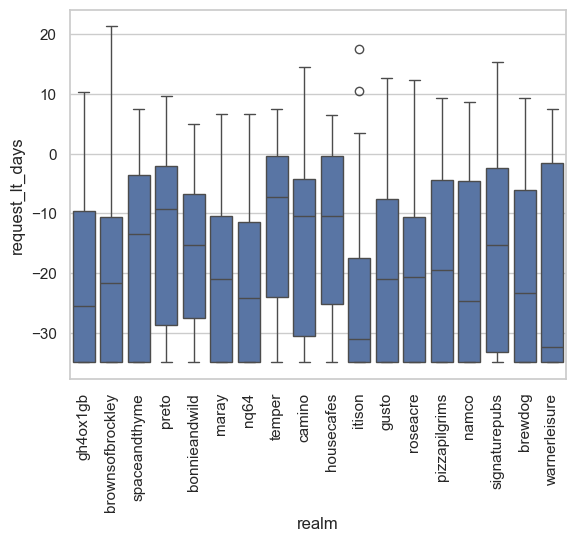

In [33]:
# plot leadtime given for absence request
# NB -ve here is GOOD as its making an absence request ahead of the scheduled work day, while +ve is BAD
# as it is a request made AFTER the scheduled work day
# 

import seaborn
 
seaborn.set(style='whitegrid')
 
ax = seaborn.boxplot(x='realm',
                y='request_lt_days',
                data=monthly_absences)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [44]:
# outliers function

import numpy as np

def get_num_outliers (column, ptile):

    #q1 = np.percentile(column, 25)
    q3 = np.percentile(column, ptile)

    return sum(column>q3) # use sum((column<q1) | (column>q3)) for ALL outliers

In [48]:
# summary for this month 

monthly_absence_summary = monthly_absences.groupby(by = ['realm'], as_index = False).apply(lambda x: pd.Series({'num_absences': x['id'].count(),
                                                                                                'total_absence_duration': x['total_days'].sum(),
                                                                                                'avg_absence_duration': x['total_hours'].mean(),
                                                                                                'avg_request_leadtime': x['request_lt_days'].mean(),
                                                                                                'num_outliers_75': get_num_outliers(x['request_lt_days'], 75),
                                                                                                'num_outliers_95': get_num_outliers(x['request_lt_days'], 95),
                                                                                                'outlier_proportion': get_num_outliers(x['request_lt_days'], 95) / x['id'].count()
                                                                                                }))

monthly_absence_summary 



/var/folders/t6/ysrkn8dn65b6bsvj1sb28p9m0000gp/T/ipykernel_31641/935312368.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_absence_summary = monthly_absences.groupby(by = ['realm'], as_index = False).apply(lambda x: pd.Series({'num_absences': x['id'].count(),


,realm,num_absences,total_absence_duration,avg_absence_duration,avg_request_leadtime,num_outliers_75,num_outliers_95,outlier_proportion
0,bonnieandwild,95.0,229.5,17.992211,-16.373012,24.0,5.0,0.052632
1,brewdog,3179.0,7400.5,17.890315,-20.444703,795.0,159.0,0.050016
2,brownsofbrockley,44.0,106.0,17.679091,-20.488802,11.0,3.0,0.068182
3,camino,174.0,396.0,18.721437,-14.970526,44.0,9.0,0.051724
4,gh4ox1gb,373.0,935.5,16.762198,-21.360412,93.0,19.0,0.050938
5,gusto,824.0,2049.5,18.523556,-20.008694,206.0,42.0,0.050971
6,housecafes,209.0,481.5,19.493014,-13.745751,52.0,11.0,0.052632
7,itison,300.0,631.0,17.503267,-24.665182,75.0,15.0,0.050000
8,maray,132.0,331.0,18.894697,-20.579307,33.0,7.0,0.053030
9,namco,1064.0,2444.0,16.878055,-20.267070,266.0,54.0,0.050752


In [36]:
most_absences = monthly_absence_summary[monthly_absence_summary.num_absences == max(monthly_absence_summary.num_absences)]
most_absences.realm.values[0]

'warnerleisure'

In [37]:
least_absences = monthly_absence_summary[monthly_absence_summary.num_absences == min(monthly_absence_summary.num_absences)]
least_absences.realm.values[0]

'brownsofbrockley'

In [49]:
longest_absences = monthly_absence_summary[monthly_absence_summary.total_absence_duration == max(monthly_absence_summary.total_absence_duration)]
longest_absences.realm.values[0]

'warnerleisure'

In [50]:
shortest_time_on_absence = monthly_absence_summary[monthly_absence_summary.total_absence_duration == min(monthly_absence_summary.total_absence_duration)]
shortest_time_on_absence.realm.values[0]

'brownsofbrockley'

In [51]:
longest_avg_absence_duration = monthly_absence_summary[monthly_absence_summary.avg_absence_duration == max(monthly_absence_summary.avg_absence_duration)]
longest_avg_absence_duration .realm.values[0]

'preto'

In [52]:
shortest_avg_absence_duration = monthly_absence_summary[monthly_absence_summary.avg_absence_duration == min(monthly_absence_summary.avg_absence_duration)]
shortest_avg_absence_duration .realm.values[0]

'roseacre'

In [38]:
earliest_absence_leadtime = monthly_absence_summary[monthly_absence_summary.avg_request_leadtime == min(monthly_absence_summary.avg_request_leadtime)]
earliest_absence_leadtime.realm.values[0]

'itison'

In [39]:
latest_absence_leadtime = monthly_absence_summary[monthly_absence_summary.avg_request_leadtime == max(monthly_absence_summary.avg_request_leadtime)]
latest_absence_requests.realm.values[0]

'temper'

In [53]:
most_num_late_absences = monthly_absence_summary[monthly_absence_summary.num_outliers_75 == max(monthly_absence_summary.num_outliers_75)]
most_num_late_absences .realm.values[0]

'warnerleisure'

In [54]:
least_num_late_absences = monthly_absence_summary[monthly_absence_summary.num_outliers_75 == min(monthly_absence_summary.num_outliers_75)]
least_num_late_absences .realm.values[0]

'brownsofbrockley'

In [55]:
most_num_last_min_absences = monthly_absence_summary[monthly_absence_summary.num_outliers_95 == max(monthly_absence_summary.num_outliers_95)]
most_num_last_min_absences .realm.values[0]

'warnerleisure'

In [56]:
least_num_last_min_absences = monthly_absence_summary[monthly_absence_summary.num_outliers_95 == min(monthly_absence_summary.num_outliers_95)]
least_num_last_min_absences .realm.values[0]

'brownsofbrockley'

In [57]:
highest_proportion_last_min_absences = monthly_absence_summary[monthly_absence_summary.outlier_proportion == max(monthly_absence_summary.outlier_proportion)]
highest_proportion_last_min_absences .realm.values[0]

'brownsofbrockley'

In [58]:
lowest_proportion_last_min_absences = monthly_absence_summary[monthly_absence_summary.outlier_proportion == min(monthly_absence_summary.outlier_proportion)]
lowest_proportion_last_min_absences .realm.values[0]

'temper'

SCRAP

In [62]:
metrics_list = ['most_absences',
                    'least_absences', 
                    'longest_absences',
                    'shortest_time_on_absence',
                    'longest_avg_absence_duration',
                    'shortest_avg_absence_duration',
                    'earliest_absence_leadtime',
                    'latest_absence_leadtime',
                    'most_num_late_absences',
                    'least_num_late_absences',
                    'most_num_last_min_absences', 
                    'least_num_last_min_absences',
                    'highest_proportion_last_min_absences',
                    'lowest_proportion_last_min_absences']
    
recommendations  = {k: "" for k in metrics_list}
recommendations

{'most_absences': '',
 'least_absences': '',
 'longest_absences': '',
 'shortest_time_on_absence': '',
 'longest_avg_absence_duration': '',
 'shortest_avg_absence_duration': '',
 'earliest_absence_leadtime': '',
 'latest_absence_leadtime': '',
 'most_num_late_absences': '',
 'least_num_late_absences': '',
 'most_num_last_min_absences': '',
 'least_num_last_min_absences': '',
 'highest_proportion_last_min_absences': '',
 'lowest_proportion_last_min_absences': ''}

In [ ]:
result = absences.groupby(['realm']).apply(lambda x: pd.Series({'num_outliers': get_num_outliers(x['request_lt_days'])}))


result



better boxplots ?

https://towardsdatascience.com/scattered-boxplots-graphing-experimental-results-with-matplotlib-seaborn-and-pandas-81f9fa8a1801
https://www.geeksforgeeks.org/boxplot-using-seaborn-in-python/